In [143]:
import pandas as pd
from gensim.models import Word2Vec
import numpy as np
from sentence_transformers import SentenceTransformer

This is part of an experiment to see if word2vec can be as good as normal bert based embedding models (without any training)
If it does perform better, this could be someplace to look. 

In [144]:
df = pd.read_csv('5-tuple-ip-flow-data/ip_flow_dataset.csv')

In [145]:
# bucket frame length into small/medium/large
def bucket_len(length):
    if length < 100: return "small"
    elif length < 1500: return "medium"
    else: return "large"

df["frame.len_bucket"] = df["frame.len"].apply(bucket_len)

In [146]:
# Construct sentences (one per flow)
sentences = df.apply(lambda row: [
    f"src:{row['ip.src']}",
    f"dst:{row['ip.dst']}",
    f"sport:{row['tcp.srcport']}",
    f"dport:{row['tcp.dstport']}",
    f"proto:{row['_ws.col.protocol']}",
    f"len:{row['frame.len_bucket']}"
], axis=1).tolist()

In [147]:
try:
    model = Word2Vec.load("ip_word2vec.model")
    model.build_vocab(sentences, update=True)
except FileNotFoundError:
    model = Word2Vec(vector_size=10,  # embedding dimension (change vector_size to alternate the embedding size)
                     window=2, # context window- how far it looks
                     min_count=1, 
                     workers=4,
                     sg=1 # skip-gram model
                    ) 
    model.build_vocab(sentences)

In [148]:
model.train(sentences, total_examples=len(sentences), epochs=50)

(32729081, 110377800)

In [149]:
model.save("ip_word2vec.model")

### How to use

In [150]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import KMeans
import numpy as np
import random
from gensim.models import Word2Vec

In [151]:
model = Word2Vec.load("ip_word2vec.model")

In [152]:
'''
def random_ip(private=False):
    if private:
        return f"172.20.0.{random.randint(1, 10)}"
    else:
        return f"{random.randint(1, 255)}.{random.randint(0, 255)}.{random.randint(0, 255)}.{random.randint(1, 255)}"
'''

'\ndef random_ip(private=False):\n    if private:\n        return f"172.20.0.{random.randint(1, 10)}"\n    else:\n        return f"{random.randint(1, 255)}.{random.randint(0, 255)}.{random.randint(0, 255)}.{random.randint(1, 255)}"\n'

In [153]:
'''
def generate_random_flow():
    flow = {
        "src": random_ip(private=False),
        "dst": random_ip(private=True),
        "sport": random.choice([80, 443, 22, 8080, 53, random.randint(1024, 65535)]),
        "dport": random.choice([80, 443, 22, 8080, 53, random.randint(1024, 65535)]),
        "proto": random.choice(["TCP", "UDP", "HTTP", "HTTPS"]),
        "len": random.choice(["tiny", "small", "medium", "large", "huge"])
    }
    return [f"src:{flow['src']}", f"dst:{flow['dst']}", f"sport:{flow['sport']}", f"dport:{flow['dport']}",
            f"proto:{flow['proto']}", f"len:{flow['len']}"]
'''

'\ndef generate_random_flow():\n    flow = {\n        "src": random_ip(private=False),\n        "dst": random_ip(private=True),\n        "sport": random.choice([80, 443, 22, 8080, 53, random.randint(1024, 65535)]),\n        "dport": random.choice([80, 443, 22, 8080, 53, random.randint(1024, 65535)]),\n        "proto": random.choice(["TCP", "UDP", "HTTP", "HTTPS"]),\n        "len": random.choice(["tiny", "small", "medium", "large", "huge"])\n    }\n    return [f"src:{flow[\'src\']}", f"dst:{flow[\'dst\']}", f"sport:{flow[\'sport\']}", f"dport:{flow[\'dport\']}",\n            f"proto:{flow[\'proto\']}", f"len:{flow[\'len\']}"]\n'

In [154]:
# this is too random
# we need to have some order so that we can understand the way it clusters
# define 3–4 "families" of IP flows with: 
# Repeating private IP ranges, common public IP prefixes, fixed protocols per group, port-pattern preferences, length-size biases

def random_ip(private=False):
    if private:
        return f"172.20.0.{random.randint(1, 10)}"
    else:
        return f"{random.randint(1, 255)}.{random.randint(0, 255)}.{random.randint(0, 255)}.{random.randint(1, 255)}"

In [155]:
def flow_gen():
    group = random.choice(["video", "web", "dns", "ssh"])
    if group == "video":
        flow = {"src": random_ip(False), "dst": random_ip(True), "sport": 443, "dport": 443, "proto": "TCP", "len": "huge"}
    elif group == "web":
        flow = {"src": random_ip(False), "dst": random_ip(True), "sport": 80, "dport": 80, "proto": "HTTP", "len": "medium"}
    elif group == "dns":
        flow = {"src": random_ip(True), "dst": random_ip(False), "sport": 53, "dport": 53, "proto": "UDP", "len": "small"}
    else:  # ssh
        flow = {"src": random_ip(False), "dst": random_ip(True), "sport": 22, "dport": 22, "proto": "TCP", "len": "tiny"}

    return [f"src:{flow['src']}", f"dst:{flow['dst']}", f"sport:{flow['sport']}", f"dport:{flow['dport']}",
            f"proto:{flow['proto']}", f"len:{flow['len']}"], group

In [156]:
flows, labels = [], []
for _ in range(100):
    f, label = flow_gen()
    flows.append(f)
    labels.append(label)

In [157]:
# now we'll compare the perfromances of this
# we'll cluster with and without embedding

In [158]:
label_map = {l: i for i, l in enumerate(set(labels))}
y_true = np.array([label_map[l] for l in labels])

In [159]:
# now we'll embed (previous was just the plain flows)
def embed_flow(flow, model):
    vectors = [model.wv[token] for token in flow if token in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

In [160]:
X_embed = np.array([embed_flow(f, model) for f in flows])

In [161]:
def transformer(flow):
    bert_model = SentenceTransformer("distilbert-base-nli-stsb-mean-tokens")
    text = " ".join(flow)
    embedding = bert_model.encode([text], convert_to_numpy=True)[0]
    normalized = embedding / np.linalg.norm(embedding)
    return normalized

In [ ]:
X_trans = np.array([transformer(f) for f in flows])

In [163]:
n_clusters = len(set(labels))
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
preds = kmeans.fit_predict(X)

In [164]:
def purity_score(y_true, y_pred):
    contingency_matrix = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-contingency_matrix)
    return contingency_matrix[row_ind, col_ind].sum() / np.sum(contingency_matrix)

In [165]:
# cluster with embeddings
kmeans_embed = KMeans(n_clusters=4, n_init=10, random_state=42)
preds_embed = kmeans_embed.fit_predict(X_embed)
purity_embed = purity_score(y_true, preds_embed)

In [166]:
# cluster with raw data
kmeans_trans = KMeans(n_clusters=4, n_init=10, random_state=42)
preds_trans = kmeans_plain.fit_predict(X_trans)
purity_trans = purity_score(y_true, preds_trans)

In [173]:
print(f"Purity (Word2Vec): {purity_embed:.4f}")
print(f"Purity (Transformer): {purity_trans:.4f}")

Purity (Word2Vec): 0.6800
Purity (Transformer): 1.0000


(0.68, 1.0, <Figure size 800x600 with 1 Axes>)

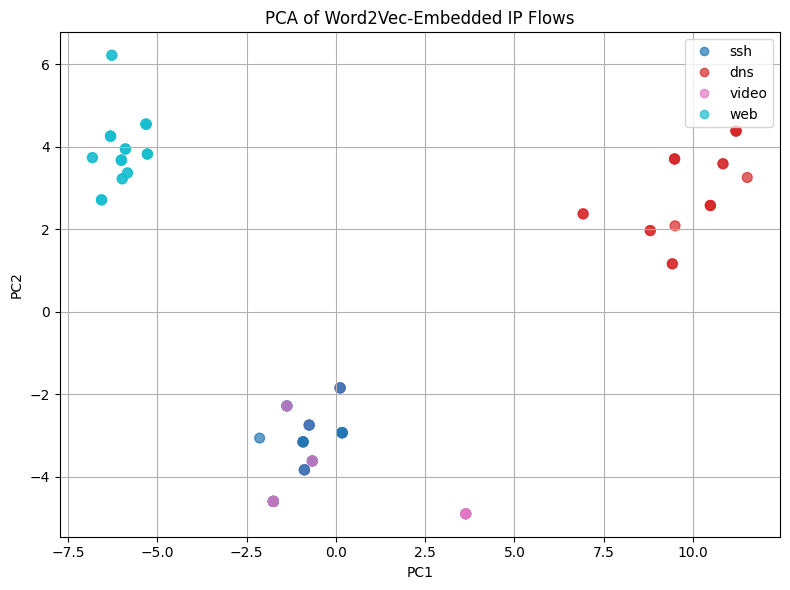

In [168]:
pca = PCA(n_components=2)
X_vis = pca.fit_transform(StandardScaler().fit_transform(X_embed))

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y_true, cmap='tab10', s=50, alpha=0.7)
plt.title("PCA of Word2Vec-Embedded IP Flows")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(handles=scatter.legend_elements()[0], labels=label_map.keys())
plt.grid(True)
plt.tight_layout()

purity_embed, purity_plain, plt.gcf()

(0.68, 1.0, <Figure size 800x600 with 1 Axes>)

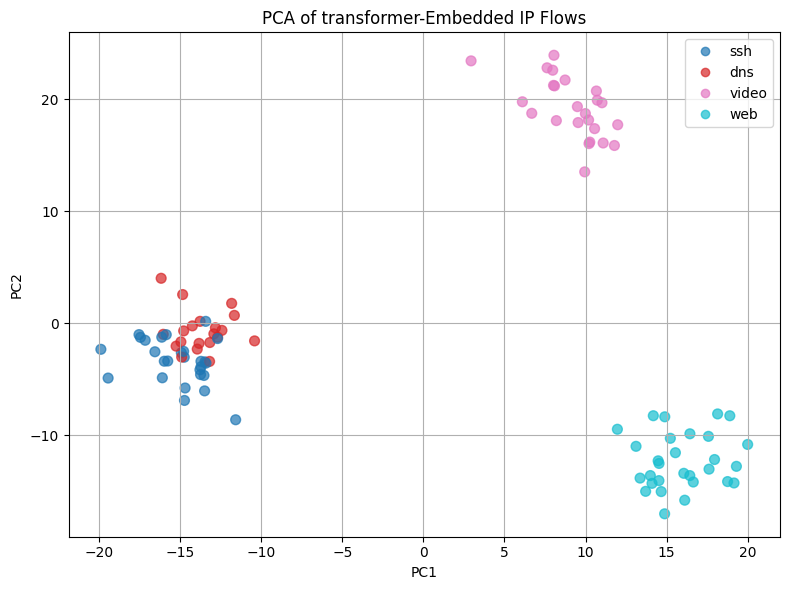

In [169]:
pca = PCA(n_components=2)
X_vis = pca.fit_transform(StandardScaler().fit_transform(X_trans))

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y_true, cmap='tab10', s=50, alpha=0.7)
plt.title("PCA of transformer-Embedded IP Flows")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(handles=scatter.legend_elements()[0], labels=label_map.keys())
plt.grid(True)
plt.tight_layout()

purity_embed, purity_plain, plt.gcf()

In [174]:
from sklearn.metrics import silhouette_score

silhouette_embed = silhouette_score(X_embed, y_pred_embed)
silhouette_trans = silhouette_score(X_trans, y_pred_trans)

print(f"Silhouette (Embedding): {silhouette_embed:.4f}")
print(f"Silhouette (Trans): {silhouette_trans:.4f}")

Silhouette (Embedding): 0.3368
Silhouette (Trans): 0.3477


In [171]:
# okay word2vec doesn't significantly improve anything. We can stick to bert. 